In [1]:
import os
import time
import uuid
import cv2

In [4]:
IMAGES_PATH = os.path.join('face_detection')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(0)  # Try using camera index 0

if not cap.isOpened():
    print("Error: Could not open camera.")
    exit()

for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    
    if not ret or frame is None:
        print("Failed to capture image")
        continue

    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.png')
    cv2.imwrite(imgname, frame)
    
    time.sleep(0.5)

cap.release()


In [15]:
!labelme

2024-08-15 20:12:55,250 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\jayap\.labelmerc


In [16]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [18]:
images = tf.data.Dataset.list_files('data\\images\\*.png')

In [19]:
images.as_numpy_iterator().next()

b'data\\images\\7a541d2e-5b14-11ef-92b9-50c2e8ba0182.png'

In [20]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [21]:
images = images.map(load_image)

In [22]:
images.as_numpy_iterator().next()

array([[[106,  43,  42],
        [109,  45,  44],
        [105,  49,  45],
        ...,
        [ 72,  91,  98],
        [ 74,  94,  97],
        [ 78,  98, 100]],

       [[102,  41,  41],
        [107,  46,  46],
        [103,  49,  45],
        ...,
        [ 72,  91,  98],
        [ 74,  94,  99],
        [ 78,  97, 102]],

       [[ 88,  27,  27],
        [106,  44,  45],
        [102,  48,  44],
        ...,
        [ 74,  93, 101],
        [ 76,  96, 103],
        [ 78,  97, 104]],

       ...,

       [[101, 134, 139],
        [101, 134, 139],
        [ 99, 133, 137],
        ...,
        [119, 148, 152],
        [114, 145, 148],
        [113, 144, 147]],

       [[102, 135, 140],
        [101, 134, 139],
        [ 99, 133, 137],
        ...,
        [119, 148, 152],
        [113, 147, 149],
        [111, 145, 147]],

       [[102, 135, 140],
        [ 99, 133, 137],
        [ 98, 132, 136],
        ...,
        [117, 148, 154],
        [115, 148, 153],
        [113, 147, 151]]

In [23]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [29]:
image_generator = images.batch(4).as_numpy_iterator()

In [33]:
plot_images = image_generator.next()

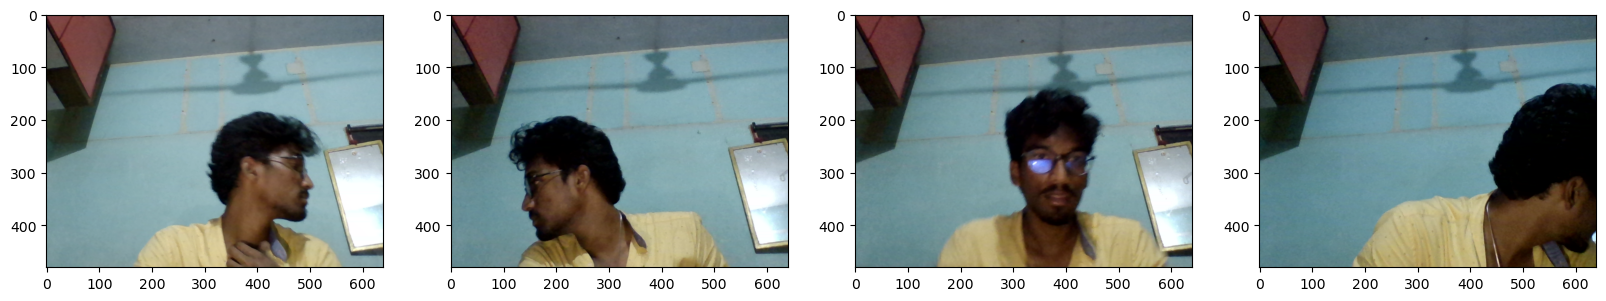

In [34]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [35]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [36]:

import albumentations as alb

In [37]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [40]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.png'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [102]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.png', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [103]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.png', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [105]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.png', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [45]:
train_images.as_numpy_iterator().next()

array([[[0.47058824, 0.5372549 , 0.5598039 ],
        [0.45490196, 0.5254902 , 0.5568628 ],
        [0.4536152 , 0.5242034 , 0.55557597],
        ...,
        [0.47561276, 0.28756127, 0.27579656],
        [0.5011029 , 0.30226716, 0.2978554 ],
        [0.52800244, 0.32310048, 0.311826  ]],

       [[0.4708946 , 0.52971816, 0.5568015 ],
        [0.475     , 0.53382355, 0.5656863 ],
        [0.4745098 , 0.53333336, 0.5647059 ],
        ...,
        [0.47389707, 0.28125   , 0.27199754],
        [0.50980395, 0.30980393, 0.29411766],
        [0.528799  , 0.3199755 , 0.29607844]],

       [[0.47432598, 0.52953434, 0.5753676 ],
        [0.4706495 , 0.5255515 , 0.5726103 ],
        [0.46286765, 0.5216299 , 0.56482846],
        ...,
        [0.48670343, 0.28713235, 0.27493873],
        [0.50447303, 0.29503676, 0.2936887 ],
        [0.5137255 , 0.30588236, 0.3019608 ]],

       ...,

       [[0.89123774, 0.91979164, 0.9175858 ],
        [0.9501838 , 0.9474878 , 0.8940564 ],
        [0.95208335, 0

In [106]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [107]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [108]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [109]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [110]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1759, 0.3086, 0.6206, 0.961 ], dtype=float16))

In [111]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 780, 780, 840, 840)

In [112]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)


In [113]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)


In [115]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [116]:

train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.2595 , 0.2778 , 0.731  , 0.959  ],
        [0.1312 , 0.     , 0.563  , 0.57   ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.5474 , 0.1564 , 0.983  , 0.579  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.1754 , 0.03668, 0.7393 , 0.6763 ]], dtype=float16))

In [117]:
data_samples = train.as_numpy_iterator()

In [118]:
res = data_samples.next()

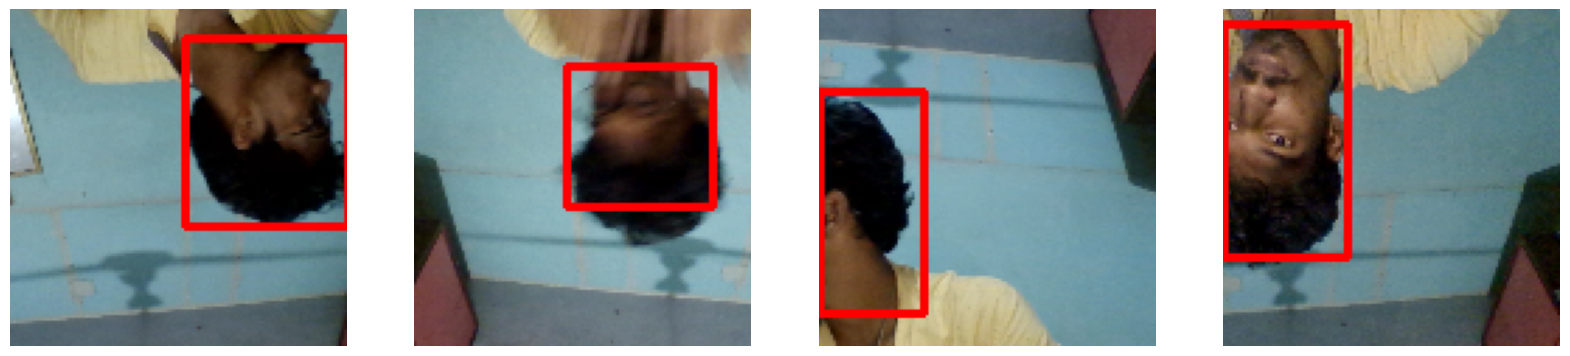

In [120]:


# Create a figure with 4 subplots
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))

# Iterate through the first 4 images and corresponding coordinates
for idx in range(4):
    sample_image = np.copy(res[0][idx])  # Make a writable copy of the image
    sample_coords = res[1][1][idx]
    
    # Draw a rectangle on the image using the coordinates
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)), 
                  (255, 0, 0), 2)

    # Display the image with the rectangle in the corresponding subplot
    ax[idx].imshow(sample_image)
    ax[idx].axis('off')  # Hide axes for better visualization

# Show the plot
plt.show()


In [121]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [122]:
vgg = VGG16(include_top=False)

In [123]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [63]:
facetracker = build_model()

In [64]:
facetracker.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                 ┃ Output Shape             ┃        Param # ┃ Connected to              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)   │ (None, 120, 120, 3)      │              0 │ -                         │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ vgg16 (Functional)           │ (None, 3, 3, 512)        │     14,714,688 │ input_layer_1[0][0]       │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ global_max_pooling2d         │ (None, 512)              │              0 │ vgg16[0][0]               │
│ (GlobalMaxPooling2D)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ global_max_pooling2d_1       │ (None, 512)              │              0 │ vgg16[0][0]               │
│ (GlobalMaxPooling2D)         │                          │                │                           │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ dense (Dense)                │ (None, 2048)             │      1,050,624 │ global_max_pooling2d[0][… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ dense_2 (Dense)              │ (None, 2048)             │      1,050,624 │ global_max_pooling2d_1[0… │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ dense_1 (Dense)              │ (None, 1)                │          2,049 │ dense[0][0]               │
├──────────────────────────────┼──────────────────────────┼────────────────┼───────────────────────────┤
│ dense_3 (Dense)              │ (None, 4)                │          8,196 │ dense_2[0][0]             │
└──────────────────────────────┴──────────────────────────┴────────────────┴───────────────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [132]:
X, y = train.as_numpy_iterator().next()

In [133]:
X.shape

(8, 120, 120, 3)

In [134]:
classes, coords = facetracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


In [135]:
classes, coords

(array([[0.5904017 ],
        [0.6405814 ],
        [0.6448541 ],
        [0.55682266],
        [0.66522753],
        [0.58232725],
        [0.5660716 ],
        [0.6885071 ]], dtype=float32),
 array([[0.4868927 , 0.45146134, 0.418246  , 0.5895091 ],
        [0.42375877, 0.42015788, 0.39568484, 0.6804061 ],
        [0.31489953, 0.5757389 , 0.34826544, 0.6212435 ],
        [0.3450091 , 0.53473353, 0.4422181 , 0.6271838 ],
        [0.45360422, 0.46050543, 0.39794895, 0.58614504],
        [0.3859143 , 0.5272174 , 0.42011216, 0.5930453 ],
        [0.423742  , 0.44102767, 0.4066622 , 0.58741844],
        [0.40270853, 0.50207335, 0.3445833 , 0.61123616]], dtype=float32))

In [126]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [128]:
batches_per_epoch
lr_decay

0.0007047216349541929

In [129]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [130]:

def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [131]:

classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [136]:

localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.8695636>

In [137]:

classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6063732>

In [138]:

regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.8695636>

In [145]:
import tensorflow as tf
from tensorflow.keras import Model

class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
    
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
        
            # Ensure shapes are defined
            y_class = tf.ensure_shape(y[0], [None, 1])
            y_coords = tf.ensure_shape(y[1], [None, 4])

            print(f"y_class (class labels) shape: {y_class.shape}")
            print(f"y_coords (coordinates) shape: {y_coords.shape}")
            print(f"Predicted classes shape: {classes.shape}")
            print(f"Predicted coordinates shape: {coords.shape}")
        
            batch_classloss = self.closs(y_class, classes)
            batch_localizationloss = self.lloss(tf.cast(y_coords, tf.float32), coords)
        
            total_loss = batch_localizationloss + 0.5 * batch_classloss
        
            grad = tape.gradient(total_loss, self.model.trainable_variables)
    
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
    
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        # Ensure shapes are defined
        y_class = tf.ensure_shape(y[0], [None, 1])
        y_coords = tf.ensure_shape(y[1], [None, 4])
        
        batch_classloss = self.closs(y_class, classes)
        batch_localizationloss = self.lloss(tf.cast(y_coords, tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [146]:
model = FaceTracker(facetracker)

In [147]:
model.compile(opt, classloss, regressloss)

In [148]:
logdir='logs'

In [149]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)